In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (VGG19 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = VGG19(weights='imagenet', input_shape=image_shape, include_top=False, pooling=None)

In [7]:
# Adding the top layer
x = Flatten(name='flatten')(base_model.output)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [9]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='virussign-vgg19-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()

In [10]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    model.set_weights(init_weights)
    
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Initial acurracy: 0.0820
Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 129s - loss: 15.1593 - acc: 0.0570 - val_loss: 15.2052 - val_acc: 0.0566
Epoch 2/100
9112/9112 [==============================] - 125s - loss: 15.1983 - acc: 0.0571 - val_loss: 15.2052 - val_acc: 0.0566
Epoch 3/100
9112/9112 [==============================] - 123s - loss: 15.1983 - acc: 0.0571 - val_loss: 15.2052 - val_acc: 0.0566
Epoch 4/100
9112/9112 [==============================] - 124s - loss: 15.1983 - acc: 0.0571 - val_loss: 15.2052 - val_acc: 0.0566
Epoch 5/100
9112/9112 [==============================] - 124s - loss: 15.1983 - acc: 0.0571 - val_loss: 15.2052 - val_acc: 0.0566
Epoch 6/100
9112/9112 [==============================] - 124s - loss: 15.1983 - acc: 0.0571 - val_loss: 15.2052 - val_acc: 0.0566
Epoch 7/100
9112/9112 [==============================] - 124s - loss: 15.1983 - acc: 0.0571 - val_loss: 15.2052 - val_acc: 0.0566
Epoch 8/100
9

9112/9112 [==============================] - 124s - loss: 15.1983 - acc: 0.0571 - val_loss: 15.2052 - val_acc: 0.0566
Epoch 64/100
9112/9112 [==============================] - 124s - loss: 15.1983 - acc: 0.0571 - val_loss: 15.2052 - val_acc: 0.0566
Epoch 65/100
9112/9112 [==============================] - 125s - loss: 15.1983 - acc: 0.0571 - val_loss: 15.2052 - val_acc: 0.0566
Epoch 66/100
9112/9112 [==============================] - 124s - loss: 15.1983 - acc: 0.0571 - val_loss: 15.2052 - val_acc: 0.0566
Epoch 67/100
9112/9112 [==============================] - 125s - loss: 15.1983 - acc: 0.0571 - val_loss: 15.2052 - val_acc: 0.0566
Epoch 68/100
9112/9112 [==============================] - 124s - loss: 15.1983 - acc: 0.0571 - val_loss: 15.2052 - val_acc: 0.0566
Epoch 69/100
9112/9112 [==============================] - 125s - loss: 15.1983 - acc: 0.0571 - val_loss: 15.2052 - val_acc: 0.0566
Epoch 70/100
9112/9112 [==============================] - 124s - loss: 15.1983 - acc: 0.0571 - v

9114/9114 [==============================] - 125s - loss: 13.8880 - acc: 0.1384 - val_loss: 13.9101 - val_acc: 0.1370
Epoch 87/100
9114/9114 [==============================] - 123s - loss: 13.8880 - acc: 0.1384 - val_loss: 13.9101 - val_acc: 0.1370
Epoch 88/100
9114/9114 [==============================] - 124s - loss: 13.8880 - acc: 0.1384 - val_loss: 13.9101 - val_acc: 0.1370
Epoch 89/100
9114/9114 [==============================] - 124s - loss: 13.8880 - acc: 0.1384 - val_loss: 13.9101 - val_acc: 0.1370
Epoch 90/100
9114/9114 [==============================] - 126s - loss: 13.8880 - acc: 0.1384 - val_loss: 13.9101 - val_acc: 0.1370
Epoch 91/100
9114/9114 [==============================] - 126s - loss: 13.8880 - acc: 0.1384 - val_loss: 13.9101 - val_acc: 0.1370
Epoch 92/100
9114/9114 [==============================] - 127s - loss: 13.8880 - acc: 0.1384 - val_loss: 13.9101 - val_acc: 0.1370
Epoch 93/100
9114/9114 [==============================] - 129s - loss: 13.8880 - acc: 0.1384 - v

9120/9120 [==============================] - 126s - loss: 15.3140 - acc: 0.0499 - val_loss: 15.3090 - val_acc: 0.0502
Epoch 9/100
9120/9120 [==============================] - 126s - loss: 15.3140 - acc: 0.0499 - val_loss: 15.3090 - val_acc: 0.0502
Epoch 10/100
9120/9120 [==============================] - 126s - loss: 15.3140 - acc: 0.0499 - val_loss: 15.3090 - val_acc: 0.0502
Epoch 11/100
9120/9120 [==============================] - 126s - loss: 15.3140 - acc: 0.0499 - val_loss: 15.3090 - val_acc: 0.0502
Epoch 12/100
9120/9120 [==============================] - 126s - loss: 15.3140 - acc: 0.0499 - val_loss: 15.3090 - val_acc: 0.0502
Epoch 13/100
9120/9120 [==============================] - 126s - loss: 15.3140 - acc: 0.0499 - val_loss: 15.3090 - val_acc: 0.0502
Epoch 14/100
9120/9120 [==============================] - 126s - loss: 15.3140 - acc: 0.0499 - val_loss: 15.3090 - val_acc: 0.0502
Epoch 15/100
9120/9120 [==============================] - 126s - loss: 15.3140 - acc: 0.0499 - va

9120/9120 [==============================] - 126s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 32/100
9120/9120 [==============================] - 126s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 33/100
9120/9120 [==============================] - 126s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 34/100
9120/9120 [==============================] - 125s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 35/100
9120/9120 [==============================] - 125s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 36/100
9120/9120 [==============================] - 125s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 37/100
9120/9120 [==============================] - 125s - loss: 13.8895 - acc: 0.1383 - val_loss: 13.8971 - val_acc: 0.1378
Epoch 38/100
9120/9120 [==============================] - 125s - loss: 13.8895 - acc: 0.1383 - v

9125/9125 [==============================] - 126s - loss: 15.3144 - acc: 0.0499 - val_loss: 15.3050 - val_acc: 0.0504
Epoch 55/100
9125/9125 [==============================] - 125s - loss: 15.3144 - acc: 0.0499 - val_loss: 15.3050 - val_acc: 0.0504
Epoch 56/100
9125/9125 [==============================] - 125s - loss: 15.3144 - acc: 0.0499 - val_loss: 15.3050 - val_acc: 0.0504
Epoch 57/100
9125/9125 [==============================] - 124s - loss: 15.3144 - acc: 0.0499 - val_loss: 15.3050 - val_acc: 0.0504
Epoch 58/100
9125/9125 [==============================] - 124s - loss: 15.3144 - acc: 0.0499 - val_loss: 15.3050 - val_acc: 0.0504
Epoch 59/100
9125/9125 [==============================] - 124s - loss: 15.3144 - acc: 0.0499 - val_loss: 15.3050 - val_acc: 0.0504
Epoch 60/100
9125/9125 [==============================] - 124s - loss: 15.3144 - acc: 0.0499 - val_loss: 15.3050 - val_acc: 0.0504
Epoch 61/100
9125/9125 [==============================] - 124s - loss: 15.3144 - acc: 0.0499 - v

9127/9127 [==============================] - 121s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 78/100
9127/9127 [==============================] - 121s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 79/100
9127/9127 [==============================] - 122s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 80/100
9127/9127 [==============================] - 122s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 81/100
9127/9127 [==============================] - 121s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 82/100
9127/9127 [==============================] - 121s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 83/100
9127/9127 [==============================] - 121s - loss: 13.8912 - acc: 0.1382 - val_loss: 13.8817 - val_acc: 0.1388
Epoch 84/100
9127/9127 [==============================] - 121s - loss: 13.8912 - acc: 0.1382 - v

1008/1008 [==============================] - 5s     
[7] Test acurracy: 0.1141 (12275.1631 s)
[8] Initial acurracy: 0.0656
Train on 9130 samples, validate on 1006 samples
Epoch 1/100
9130/9130 [==============================] - 127s - loss: 14.2616 - acc: 0.1130 - val_loss: 14.2916 - val_acc: 0.1133
Epoch 2/100
9130/9130 [==============================] - 125s - loss: 14.2927 - acc: 0.1133 - val_loss: 14.2916 - val_acc: 0.1133
Epoch 3/100
9130/9130 [==============================] - 125s - loss: 14.2927 - acc: 0.1133 - val_loss: 14.2916 - val_acc: 0.1133
Epoch 4/100
9130/9130 [==============================] - 126s - loss: 14.2927 - acc: 0.1133 - val_loss: 14.2916 - val_acc: 0.1133
Epoch 5/100
9130/9130 [==============================] - 126s - loss: 14.2927 - acc: 0.1133 - val_loss: 14.2916 - val_acc: 0.1133
Epoch 6/100
9130/9130 [==============================] - 126s - loss: 14.2927 - acc: 0.1133 - val_loss: 14.2916 - val_acc: 0.1133
Epoch 7/100
9130/9130 [==========================

9132/9132 [==============================] - 126s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 23/100
9132/9132 [==============================] - 127s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 24/100
9132/9132 [==============================] - 127s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 25/100
9132/9132 [==============================] - 126s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 26/100
9132/9132 [==============================] - 127s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 27/100
9132/9132 [==============================] - 126s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 28/100
9132/9132 [==============================] - 127s - loss: 13.8924 - acc: 0.1381 - val_loss: 13.8706 - val_acc: 0.1394
Epoch 29/100
9132/9132 [==============================] - 126s - loss: 13.8924 - acc: 0.1381 - v

In [11]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.1074


In [12]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Accuracy.pdf', format='pdf')
    plt.show()

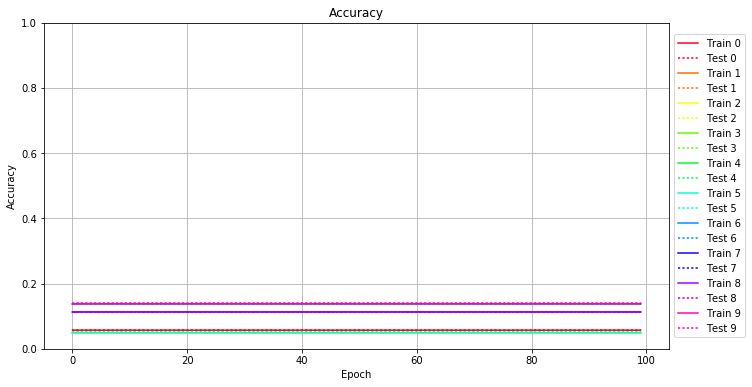

In [13]:
plot_acc(history)

In [14]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Loss.pdf', format='pdf')
    plt.show()

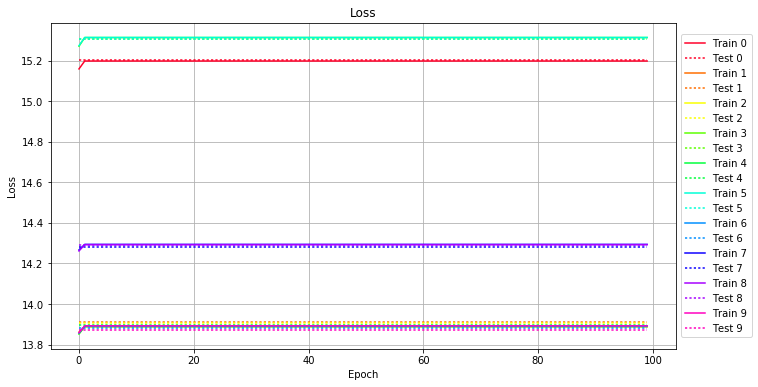

In [15]:
plot_loss(history)

Plotting the confusion matrix


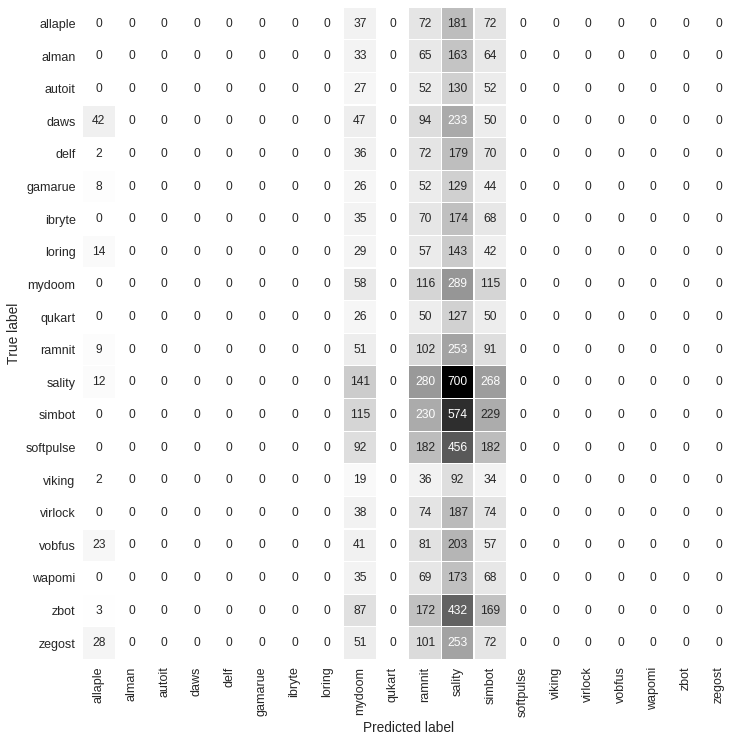

In [16]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 12}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


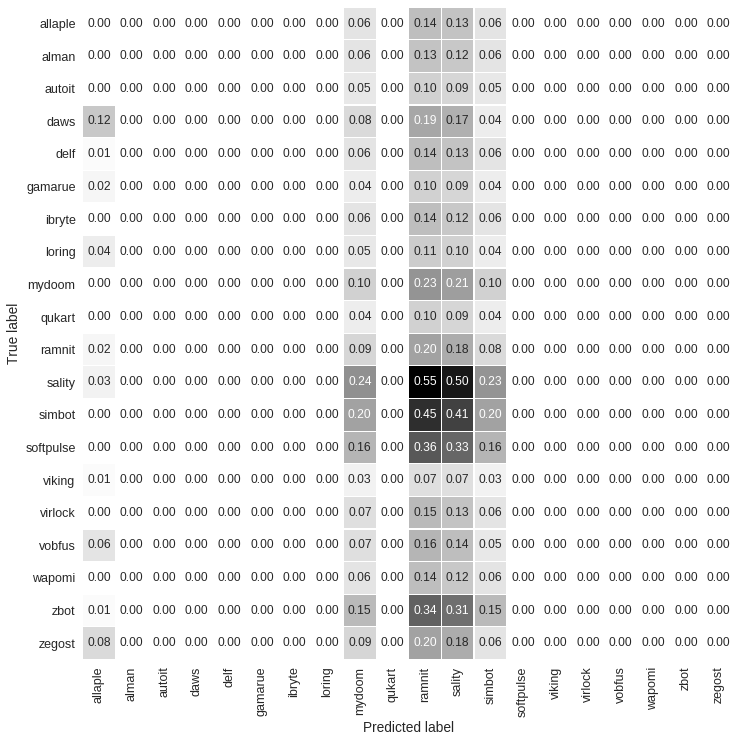

In [17]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 12}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [18]:
for h in history:
    print(h.history)

{'acc': [0.056957857776514999, 0.057067603160667252, 0.05706760316393792, 0.05706760316393792, 0.057067603160667252, 0.05706760316393792, 0.057067603167208589, 0.057067603173749919, 0.05706760316393792, 0.057067603167208589, 0.057067603167208589, 0.05706760316393792, 0.05706760316393792, 0.057067603160667252, 0.057067603160667252, 0.057067603160667252, 0.05706760316393792, 0.057067603167208589, 0.05706760316393792, 0.057067603160667252, 0.057067603167208589, 0.05706760316393792, 0.057067603160667252, 0.057067603160667252, 0.057067603160667252, 0.057067603167208589, 0.057067603160667252, 0.05706760316393792, 0.05706760316393792, 0.05706760316393792, 0.057067603160667252, 0.057067603167208589, 0.05706760316393792, 0.057067603167208589, 0.057067603160667252, 0.057067603167208589, 0.057067603167208589, 0.05706760316393792, 0.057067603160667252, 0.05706760316393792, 0.05706760316393792, 0.05706760316393792, 0.057067603160667252, 0.057067603167208589, 0.057067603167208589, 0.0570676031639379

In [19]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

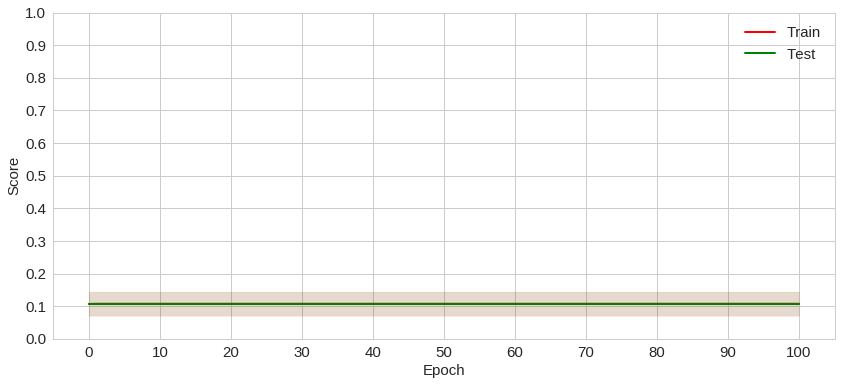

In [20]:
plot_mean_acc(history)

In [21]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

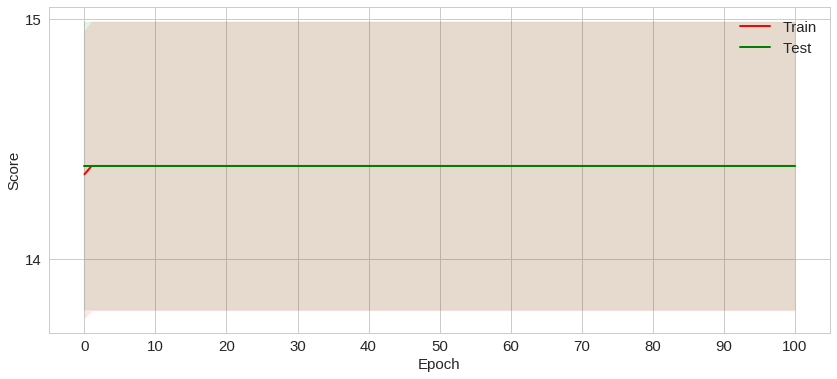

In [22]:
plot_mean_loss(history)

In [24]:
hist = [{'acc': [0.056957857776514999, 0.057067603160667252, 0.05706760316393792, 0.05706760316393792, 0.057067603160667252, 0.05706760316393792, 0.057067603167208589, 0.057067603173749919, 0.05706760316393792, 0.057067603167208589, 0.057067603167208589, 0.05706760316393792, 0.05706760316393792, 0.057067603160667252, 0.057067603160667252, 0.057067603160667252, 0.05706760316393792, 0.057067603167208589, 0.05706760316393792, 0.057067603160667252, 0.057067603167208589, 0.05706760316393792, 0.057067603160667252, 0.057067603160667252, 0.057067603160667252, 0.057067603167208589, 0.057067603160667252, 0.05706760316393792, 0.05706760316393792, 0.05706760316393792, 0.057067603160667252, 0.057067603167208589, 0.05706760316393792, 0.057067603167208589, 0.057067603160667252, 0.057067603167208589, 0.057067603167208589, 0.05706760316393792, 0.057067603160667252, 0.05706760316393792, 0.05706760316393792, 0.05706760316393792, 0.057067603160667252, 0.057067603167208589, 0.057067603167208589, 0.05706760316393792, 0.05706760316393792, 0.057067603167208589, 0.057067603167208589, 0.057067603160667252, 0.057067603160667252, 0.05706760316393792, 0.057067603160667252, 0.05706760316393792, 0.05706760316393792, 0.05706760316393792, 0.057067603167208589, 0.057067603167208589, 0.057067603173749919, 0.057067603167208589, 0.057067603160667252, 0.057067603160667252, 0.057067603160667252, 0.057067603167208589, 0.05706760316393792, 0.05706760316393792, 0.05706760316393792, 0.05706760316393792, 0.057067603167208589, 0.05706760316393792, 0.057067603160667252, 0.05706760316393792, 0.057067603160667252, 0.05706760316393792, 0.057067603160667252, 0.05706760316393792, 0.05706760316393792, 0.057067603160667252, 0.05706760316393792, 0.05706760316393792, 0.057067603160667252, 0.057067603160667252, 0.05706760316393792, 0.05706760316393792, 0.057067603167208589, 0.05706760316393792, 0.057067603160667252, 0.057067603160667252, 0.057067603160667252, 0.057067603160667252, 0.05706760316393792, 0.057067603160667252, 0.05706760316393792, 0.057067603167208589, 0.057067603167208589, 0.057067603167208589, 0.057067603160667252, 0.057067603167208589, 0.05706760316393792, 0.057067603167208589], 'loss': [15.15929614796358, 15.198274017950231, 15.198274079909757, 15.198274059814775, 15.198274051441865, 15.198274093306409, 15.198274041394376, 15.198274048929994, 15.198274093306409, 15.198274034696048, 15.198274088282664, 15.198274019624812, 15.198274086608082, 15.19827406483852, 15.198274024648558, 15.198274058140193, 15.198274086608082, 15.198274048092703, 15.198274039719793, 15.198274038045211, 15.198274007902739, 15.198274039719793, 15.198274017950231, 15.198274078235174, 15.198273997855249, 15.19827405479103, 15.198274058140193, 15.198274066513102, 15.198274046418121, 15.198274079909757, 15.198274078235174, 15.198274034696048, 15.198274086608082, 15.198274048092703, 15.198274036370631, 15.198274068187683, 15.19827405479103, 15.198274053116448, 15.198274038045211, 15.198274026323139, 15.198274033021466, 15.198274019624812, 15.198274071536847, 15.198274088282664, 15.198273994506085, 15.198274026323139, 15.198274033021466, 15.198274034696048, 15.1982741217743, 15.198274031346884, 15.198274044743538, 15.198274039719793, 15.19827405646561, 15.198274066513102, 15.198274046418121, 15.198274053116448, 15.198274081584337, 15.198274068187683, 15.198274062326647, 15.19827407488601, 15.198274033858757, 15.198274009577322, 15.198274022973976, 15.198274021299394, 15.198274066513102, 15.198274066513102, 15.198274066513102, 15.198274033021466, 15.198274048092703, 15.198274073211429, 15.198274031346884, 15.198274079909757, 15.198274051441865, 15.198274053116448, 15.198274024648558, 15.198274059814775, 15.198274033021466, 15.198274089957247, 15.198274079909757, 15.198274059814775, 15.198274024648558, 15.198274044743538, 15.198274066513102, 15.198274059814775, 15.198274068187683, 15.198274026323139, 15.198274084933502, 15.198274011251904, 15.198274078235174, 15.198274038045211, 15.198274073211429, 15.198274111726809, 15.198274100004737, 15.198274007902739, 15.198274048092703, 15.198274068187683, 15.198274078235174, 15.198274041394376, 15.198274066513102, 15.198274061489357], 'val_acc': [0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625, 0.056640625], 'val_loss': [15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751, 15.205156400799751]},
{'acc': [0.13791968400263332, 0.1383585692382327, 0.13835856926030488, 0.13835856925703491, 0.13835856925703491, 0.13835856926684476, 0.13835856928646448, 0.13835856928646448, 0.13835856925049503, 0.13835856925703491, 0.13835856925703491, 0.13835856927992457, 0.13835856928646448, 0.1383585692382327, 0.13835856927338466, 0.13835856925703491, 0.13835856925049503, 0.13835856925049503, 0.1383585692382327, 0.13835856924395512, 0.13835856924232015, 0.13835856928646448, 0.13835856925049503, 0.13835856925703491, 0.13835856925703491, 0.13835856925049503, 0.13835856926030488, 0.13835856925703491, 0.13835856925049503, 0.13835856925703491, 0.13835856925703491, 0.13835856925703491, 0.13835856925049503, 0.13835856923741521, 0.13835856924232015, 0.13835856927992457, 0.1383585692382327, 0.13835856925049503, 0.13835856924395512, 0.13835856928646448, 0.13835856927992457, 0.13835856925049503, 0.13835856925703491, 0.1383585692382327, 0.13835856925703491, 0.13835856925049503, 0.13835856924232015, 0.13835856925049503, 0.13835856924232015, 0.13835856925049503, 0.13835856924232015, 0.13835856925703491, 0.13835856933878365, 0.13835856925703491, 0.13835856925703491, 0.13835856925703491, 0.13835856925703491, 0.13835856925703491, 0.1383585692382327, 0.13835856924232015, 0.13835856927992457, 0.13835856925703491, 0.13835856925049503, 0.13835856925049503, 0.13835856925049503, 0.13835856928646448, 0.13835856925703491, 0.13835856925703491, 0.13835856925049503, 0.1383585692382327, 0.13835856924232015, 0.13835856935186347, 0.13835856925049503, 0.13835856923414527, 0.13835856925049503, 0.13835856925703491, 0.1383585692382327, 0.13835856928646448, 0.13835856925049503, 0.13835856927338466, 0.13835856925703491, 0.13835856924232015, 0.13835856925703491, 0.13835856925703491, 0.13835856927992457, 0.1383585692382327, 0.1383585692382327, 0.13835856925049503, 0.13835856925703491, 0.13835856924232015, 0.13835856925703491, 0.13835856925703491, 0.13835856925049503, 0.13835856927338466, 0.13835856925703491, 0.13835856924232015, 0.13835856927338466, 0.13835856925049503, 0.13835856925049503, 0.13835856924232015], 'loss': [13.861842140597892, 13.888018830973039, 13.888018812138128, 13.888018767352897, 13.88801878472287, 13.888018689920486, 13.888018751866413, 13.888018765260128, 13.888018799790798, 13.88801878472287, 13.888018798116583, 13.888018746843771, 13.888018751866413, 13.888018817579326, 13.888018835577128, 13.888018760656038, 13.888018790373343, 13.888018833275083, 13.888018764004467, 13.888018701012156, 13.888018725497538, 13.888018778653842, 13.888018759609656, 13.888018760656038, 13.888018764632298, 13.888018730101628, 13.888018751866413, 13.888018751238583, 13.888018726125368, 13.888018744541727, 13.888018780746611, 13.888018771329156, 13.888018786397083, 13.888018787024913, 13.888018758981826, 13.888018766934342, 13.888018697035896, 13.888018786397083, 13.888018725078986, 13.888018845622414, 13.888018807115486, 13.888018790373343, 13.888018798116583, 13.888018717126467, 13.888018733868611, 13.888018776979628, 13.888018758981826, 13.888018799790798, 13.888018765678682, 13.888018783676486, 13.888018772375538, 13.888018731148012, 13.888018683851458, 13.888018794140326, 13.888018807534039, 13.888018791419727, 13.888018735124271, 13.888018794140326, 13.888018730520182, 13.888018765678682, 13.888018760237486, 13.888018747262326, 13.888018756889057, 13.888018779700227, 13.888018776979628, 13.888018758563272, 13.888018818207156, 13.888018814230897, 13.888018739519083, 13.888018770701326, 13.888018745588111, 13.888018730101628, 13.888018776979628, 13.888018809208253, 13.888018736798486, 13.888018794140326, 13.888018683642182, 13.888018765260128, 13.888018752912798, 13.888018741821128, 13.888018778026012, 13.888018809836083, 13.888018798116583, 13.888018774049753, 13.888018753540628, 13.888018737217038, 13.888018764004467, 13.888018770282772, 13.888018795395986, 13.888018692013253, 13.888018677573156, 13.888018768608557, 13.888018756889057, 13.888018775305413, 13.888018775305413, 13.888018718800682, 13.888018768608557, 13.888018770282772, 13.888018786397083, 13.888018732194396], 'val_acc': [0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301, 0.13698630136986301], 'val_loss': [13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706, 13.910137131722706]},
{'acc': [0.13734093902141392, 0.13832821414861934, 0.13832821413881163, 0.13832821414208088, 0.13832821418131167, 0.13832821413390781, 0.13832821413881163, 0.13832821418131167, 0.13832821414861934, 0.13832821414861934, 0.13832821415515781, 0.13832821418131167, 0.13832821414861934, 0.13832821415515781, 0.13832821413390781, 0.13832821412900395, 0.13832821418131167, 0.13832821415515781, 0.13832821414861934, 0.13832821414208088, 0.13832821414208088, 0.13832821418131167, 0.13832821414861934, 0.13832821413881163, 0.13832821414208088, 0.13832821413881163, 0.13832821415515781, 0.13832821414208088, 0.13832821412900395, 0.13832821415515781, 0.13832821413881163, 0.13832821413881163, 0.13832821413881163, 0.13832821415515781, 0.13832821412900395, 0.13832821418131167, 0.13832821414208088, 0.13832821414861934, 0.13832821414861934, 0.13832821418131167, 0.13832821414208088, 0.13832821415515781, 0.13832821422054245, 0.13832821414861934, 0.13832821413881163, 0.13832821414208088, 0.13832821414861934, 0.13832821414208088, 0.13832821414861934, 0.13832821415515781, 0.13832821418131167, 0.13832821414861934, 0.13832821414861934, 0.13832821414861934, 0.13832821413390781, 0.13832821414208088, 0.13832821414861934, 0.13832821413881163, 0.13832821414208088, 0.13832821413390781, 0.13832821413881163, 0.13832821415515781, 0.13832821413881163, 0.13832821414208088, 0.13832821415515781, 0.13832821413881163, 0.13832821414208088, 0.13832821424669631, 0.13832821415515781, 0.13832821413881163, 0.13832821414861934, 0.13832821414208088, 0.13832821414208088, 0.13832821413881163, 0.13832821414208088, 0.13832821413881163, 0.13832821413881163, 0.13832821413554242, 0.13832821415515781, 0.13832821415515781, 0.13832821414861934, 0.13832821414861934, 0.13832821414208088, 0.13832821415515781, 0.13832821415515781, 0.13832821415515781, 0.13832821414861934, 0.13832821414208088, 0.13832821414861934, 0.13832821414861934, 0.13832821418131167, 0.13832821413554242, 0.13832821414861934, 0.13832821413390781, 0.13832821413881163, 0.13832821415515781, 0.13832821414208088, 0.13832821414208088, 0.13832821414861934, 0.13832821414861934], 'loss': [13.852596450343682, 13.888508020026896, 13.888508009565353, 13.888508027140746, 13.888507976925336, 13.888507995756115, 13.888508063128455, 13.888508023793053, 13.88850803048844, 13.888508020026896, 13.88850799952227, 13.888508057269991, 13.888508053503836, 13.888508026303823, 13.888508009146891, 13.888508082377696, 13.888508050574604, 13.888508073171538, 13.888507999940732, 13.888507993663806, 13.888508067313074, 13.888507970229949, 13.888507966463793, 13.888508009565353, 13.888508027140746, 13.888508022956128, 13.88850799952227, 13.888508020445357, 13.888507963953023, 13.888507952654555, 13.888508063128455, 13.888508083214619, 13.888508089910008, 13.888508046389987, 13.888508010820738, 13.888508084051542, 13.888508060617685, 13.888507999940732, 13.888508080285387, 13.888508043879215, 13.888508027140746, 13.888508066476151, 13.888507994500729, 13.888508046808449, 13.888507989479189, 13.88850804722691, 13.888508026722285, 13.888508040531521, 13.888507973159181, 13.888508046389987, 13.888507983620725, 13.888507979854568, 13.888508006636121, 13.888507966463793, 13.888508029233055, 13.888508020445357, 13.888508033417672, 13.88850801626074, 13.888508033836134, 13.88850807610077, 13.888508022956128, 13.888508005380736, 13.88850801626074, 13.888508007054583, 13.888508026303823, 13.888507969393025, 13.888508033836134, 13.888507971903795, 13.888507952654555, 13.888508022956128, 13.888507953073017, 13.888507933405315, 13.888507953491478, 13.888507989479189, 13.888508027140746, 13.888508036346904, 13.888508002869965, 13.888507994082268, 13.888507986131495, 13.888507966045331, 13.888508026722285, 13.88850807359, 13.88850801374997, 13.888508059780762, 13.888508053085374, 13.888508019608434, 13.888508026722285, 13.888508040531521, 13.888508090746932, 13.888508026722285, 13.888508017097664, 13.888507994082268, 13.888507999940732, 13.88850804262383, 13.888508022956128, 13.888508019608434, 13.88850801374997, 13.88850801374997, 13.888507999940732, 13.888508033417672], 'val_acc': [0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433, 0.13725490196078433], 'val_loss': [13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101, 13.905807943905101]},
{'acc': [0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985, 0.049890350877192985], 'loss': [15.271036663390042, 15.313957702904418, 15.313957702904418, 15.313957669442161, 15.313957689519514, 15.313957676134612, 15.31395771628932, 15.313957689519514, 15.313957666095934, 15.313957689519514, 15.313957696211965, 15.31395771628932, 15.313957669442161, 15.313957682827063, 15.31395766274971, 15.313957629287453, 15.313957699558191, 15.313957702904418, 15.31395774640535, 15.313957669442161, 15.313957709596869, 15.313957656057257, 15.313957706250642, 15.313957726327997, 15.313957689519514, 15.313957669442161, 15.313957669442161, 15.313957702904418, 15.313957702904418, 15.313957682827063, 15.313957709596869, 15.313957709596869, 15.313957696211965, 15.313957676134612, 15.313957669442161, 15.313957702904418, 15.313957676134612, 15.313957722981771, 15.313957676134612, 15.313957706250642, 15.313957706250642, 15.313957679480836, 15.313957689519514, 15.313957729674222, 15.31395771628932, 15.313957702904418, 15.313957669442161, 15.313957689519514, 15.31395766274971, 15.313957702904418, 15.313957682827063, 15.313957682827063, 15.313957656057257, 15.313957676134612, 15.313957679480836, 15.313957699558191, 15.31395771628932, 15.313957676134612, 15.313957669442161, 15.313957702904418, 15.31395771628932, 15.313957702904418, 15.313957669442161, 15.31395766274971, 15.313957729674222, 15.31395771628932, 15.313957649364806, 15.31395769286574, 15.313957709596869, 15.313957669442161, 15.313957682827063, 15.313957696211965, 15.313957696211965, 15.313957689519514, 15.313957729674222, 15.313957696211965, 15.313957702904418, 15.313957702904418, 15.313957709596869, 15.313957729674222, 15.313957702904418, 15.313957709596869, 15.313957682827063, 15.31395769286574, 15.313957709596869, 15.313957676134612, 15.313957689519514, 15.313957729674222, 15.31395771628932, 15.313957682827063, 15.313957722981771, 15.313957696211965, 15.313957669442161, 15.313957689519514, 15.313957689519514, 15.313957682827063, 15.31395766274971, 15.31395766274971, 15.313957756444028, 15.313957709596869], 'val_acc': [0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788, 0.050196850393700788], 'val_loss': [15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225, 15.309017752099225]},
{'acc': [0.13750000000000001, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912, 0.13826754385964912], 'loss': [13.85227195338199, 13.889485931396484, 13.88948590462668, 13.889485894588002, 13.889485887895551, 13.889485944781388, 13.889485944781388, 13.889485871164423, 13.889485938088935, 13.889485897934227, 13.889485891241776, 13.889485944781388, 13.88948595816629, 13.889485877856874, 13.88948586447197, 13.889485984936096, 13.889485877856874, 13.889485924704033, 13.889485931396484, 13.889485938088935, 13.889485924704033, 13.889485891241776, 13.889485891241776, 13.889485911319131, 13.889485938088935, 13.889485914665356, 13.889485924704033, 13.889485844394617, 13.88948593474271, 13.88948593474271, 13.889485944781388, 13.88948586447197, 13.889485974897418, 13.88948590462668, 13.889485877856874, 13.88948593474271, 13.889485924704033, 13.88948595816629, 13.889485938088935, 13.889485857779519, 13.889485854433294, 13.889485897934227, 13.889485951473839, 13.889485897934227, 13.889485931396484, 13.889485841048391, 13.889485901280453, 13.889485844394617, 13.889485918011582, 13.889485891241776, 13.889485924704033, 13.889485961512515, 13.889485891241776, 13.889485844394617, 13.889485911319131, 13.889485931396484, 13.889485847740843, 13.889485871164423, 13.889485891241776, 13.889485931396484, 13.889485941435161, 13.889485924704033, 13.889485924704033, 13.889485924704033, 13.889485807586135, 13.889485874510648, 13.889485891241776, 13.889485918011582, 13.889485991628547, 13.889485871164423, 13.88948586447197, 13.889485951473839, 13.889485887895551, 13.889485837702166, 13.889485918011582, 13.889485981589869, 13.889485884549325, 13.88948595816629, 13.889485891241776, 13.889485897934227, 13.889485924704033, 13.88948595816629, 13.889485931396484, 13.889485924704033, 13.889485984936096, 13.88948590462668, 13.889485897934227, 13.889485871164423, 13.889485894588002, 13.889485851087068, 13.889485897934227, 13.88948590462668, 13.889485897934227, 13.889485964858741, 13.889485921357807, 13.889485931396484, 13.889485968204967, 13.889485944781388, 13.889485941435161, 13.889485918011582], 'val_acc': [0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119, 0.13779527559055119], 'val_loss': [13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244, 13.897098038140244]},
{'acc': [0.049534246577996099, 0.049863013709244661, 0.049863013701283772, 0.049863013703937399, 0.049863013698630138, 0.049863013701283772, 0.049863013714143672, 0.049863013701283772, 0.049863013698630138, 0.049863013714143672, 0.049863013714143672, 0.049863013703937399, 0.049863013701283772, 0.049863013703937399, 0.049863013714143672, 0.049863013703937399, 0.049863013709244661, 0.049863013701283772, 0.049863013703937399, 0.049863013698630138, 0.049863013701283772, 0.049863013703937399, 0.049863013701283772, 0.049863013703937399, 0.049863013703937399, 0.049863013714143672, 0.049863013703937399, 0.049863013701283772, 0.049863013701283772, 0.049863013734556226, 0.049863013701283772, 0.049863013703937399, 0.049863013701283772, 0.049863013709244661, 0.049863013698630138, 0.049863013734556226, 0.049863013701283772, 0.049863013734556226, 0.049863013703937399, 0.049863013703937399, 0.049863013714143672, 0.049863013701283772, 0.049863013701283772, 0.049863013698630138, 0.049863013703937399, 0.049863013701283772, 0.049863013703937399, 0.049863013714143672, 0.049863013698630138, 0.049863013703937399, 0.049863013709244661, 0.049863013703937399, 0.049863013701283772, 0.049863013701283772, 0.049863013703937399, 0.049863013703937399, 0.049863013698630138, 0.049863013698630138, 0.049863013701283772, 0.049863013714143672, 0.049863013703937399, 0.049863013703937399, 0.049863013698630138, 0.049863013714143672, 0.049863013714143672, 0.049863013701283772, 0.049863013701283772, 0.049863013714143672, 0.049863013703937399, 0.049863013703937399, 0.049863013703937399, 0.049863013703937399, 0.049863013701283772, 0.049863013724758203, 0.049863013698630138, 0.049863013701283772, 0.049863013714143672, 0.049863013698630138, 0.049863013698630138, 0.049863013709244661, 0.049863013701283772, 0.049863013701283772, 0.049863013701283772, 0.049863013698630138, 0.049863013698630138, 0.049863013703937399, 0.049863013701283772, 0.049863013709244661, 0.049863013709244661, 0.049863013701283772, 0.049863013701283772, 0.049863013701283772, 0.049863013701283772, 0.049863013701283772, 0.049863013703937399, 0.049863013703937399, 0.049863013701283772, 0.049863013703937399, 0.049863013703937399, 0.049863013714143672], 'loss': [15.273782902965808, 15.3143983308975, 15.314398344693119, 15.314398315220663, 15.31439830623261, 15.314398344693119, 15.314398325880912, 15.314398334137381, 15.314398353054099, 15.314398316370298, 15.314398292436991, 15.314398308531878, 15.314398324626765, 15.314398308531878, 15.314398285748208, 15.314398308531878, 15.314398320341763, 15.314398324626765, 15.314398321909447, 15.314398319610177, 15.314398317937982, 15.314398308531878, 15.314398338004334, 15.314398321909447, 15.314398341975799, 15.314398332569697, 15.314398321909447, 15.314398324626765, 15.314398291182844, 15.314398341557752, 15.314398277805276, 15.314398308531878, 15.314398311249198, 15.314398310831148, 15.314398319610177, 15.314398341557752, 15.314398338004334, 15.314398321491398, 15.314398321909447, 15.314398308531878, 15.314398325880912, 15.314398304560413, 15.314398304560413, 15.314398279477473, 15.314398321909447, 15.31439833131555, 15.314398341975799, 15.314398325880912, 15.314398332987746, 15.314398335287017, 15.314398337586285, 15.314398328598232, 15.314398317937982, 15.314398307382245, 15.314398321909447, 15.314398281776741, 15.314398286166256, 15.314398332987746, 15.314398324626765, 15.314398299125775, 15.314398348664584, 15.314398341975799, 15.314398299543825, 15.314398329747867, 15.314398325880912, 15.314398284494061, 15.314398324626765, 15.314398299125775, 15.314398301843095, 15.314398335287017, 15.314398281776741, 15.314398301843095, 15.314398297871628, 15.314398297035531, 15.314398332987746, 15.314398271116492, 15.314398286793329, 15.314398346365314, 15.314398319610177, 15.314398350963854, 15.314398314071028, 15.314398297871628, 15.314398391514608, 15.31439830623261, 15.314398312921393, 15.314398301843095, 15.314398317937982, 15.31439831365298, 15.314398264009659, 15.314398317937982, 15.314398304560413, 15.314398307382245, 15.314398340826164, 15.314398304560413, 15.314398315220663, 15.314398295154311, 15.314398317937982, 15.314398308531878, 15.314398355353369, 15.314398313548468], 'val_acc': [0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766, 0.050445103857566766], 'val_loss': [15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349, 15.305016378974349]},
{'acc': [0.13728497866584005, 0.13816149885242435, 0.13816149888058749, 0.13816149885242435, 0.1381614988740569, 0.13816149892466895, 0.13816149886752632, 0.1381614988740569, 0.13816149886752632, 0.13816149888058749, 0.13816149890507717, 0.1381614988740569, 0.13816149886099574, 0.13816149886181206, 0.13816149885528148, 0.13816149890507717, 0.13816149888058749, 0.1381614988740569, 0.13816149886752632, 0.13816149886752632, 0.1381614988740569, 0.13816149886752632, 0.13816149886752632, 0.1381614988740569, 0.1381614988740569, 0.1381614988740569, 0.1381614988740569, 0.13816149886099574, 0.13816149886099574, 0.13816149885528148, 0.13816149885242435, 0.13816149885242435, 0.13816149885528148, 0.13816149888058749, 0.13816149886181206, 0.13816149891813836, 0.13816149888058749, 0.1381614988740569, 0.13816149886181206, 0.13816149888058749, 0.1381614988740569, 0.1381614988740569, 0.1381614988740569, 0.13816149888058749, 0.13816149888058749, 0.13816149886181206, 0.13816149888058749, 0.13816149886099574, 0.13816149891160778, 0.13816149886181206, 0.1381614988740569, 0.13816149888058749, 0.13816149885528148, 0.13816149885528148, 0.13816149885528148, 0.1381614988740569, 0.13816149885528148, 0.1381614988740569, 0.13816149886752632, 0.13816149886099574, 0.13816149886181206, 0.13816149884956722, 0.13816149885528148, 0.1381614988509958, 0.13816149888058749, 0.13816149886181206, 0.13816149886181206, 0.13816149886099574, 0.13816149888058749, 0.13816149885528148, 0.13816149886181206, 0.13816149886181206, 0.1381614988740569, 0.13816149886752632, 0.13816149886099574, 0.13816149886752632, 0.13816149888058749, 0.13816149886099574, 0.13816149885528148, 0.13816149886181206, 0.13816149888058749, 0.13816149886752632, 0.13816149891813836, 0.13816149888058749, 0.13816149885528148, 0.13816149886181206, 0.13816149885528148, 0.13816149885528148, 0.1381614988740569, 0.1381614988740569, 0.13816149888058749, 0.13816149885528148, 0.13816149885242435, 0.13816149885528148, 0.13816149888058749, 0.1381614988740569, 0.13816149888058749, 0.13816149891160778, 0.13816149885528148, 0.13816149888058749], 'loss': [13.856585463754472, 13.891195164957692, 13.891195132461503, 13.891195138208417, 13.891195201006518, 13.891195124102355, 13.891195115743207, 13.891195140820651, 13.891195098293485, 13.891195219396643, 13.891195125042758, 13.89119512483378, 13.891195177600903, 13.891195119818292, 13.891195124102355, 13.891195221277451, 13.891195172585414, 13.891195120758695, 13.891195169241755, 13.89119514249248, 13.891195140820651, 13.89119514249248, 13.891195088993932, 13.891195164957692, 13.891195171645009, 13.891195185019647, 13.891195194319199, 13.891195104040399, 13.891195130789674, 13.891195110727718, 13.891195185019647, 13.891195131521098, 13.891195150851628, 13.891195212709325, 13.891195186691476, 13.891195152523458, 13.891195199334687, 13.891195194319199, 13.891195119818292, 13.891195132461503, 13.891195160882607, 13.891195194319199, 13.891195111459142, 13.891195139148822, 13.891195223471728, 13.891195166629521, 13.89119516997318, 13.891195150851628, 13.891195134133332, 13.891195200066113, 13.891195087322103, 13.891195152523458, 13.891195161614032, 13.891195124102355, 13.891195154926713, 13.891195187631881, 13.891195268611128, 13.891195164957692, 13.891195175929074, 13.891195177600903, 13.891195135805162, 13.891195168301351, 13.891195130789674, 13.891195109787313, 13.891195212709325, 13.891195193378795, 13.891195186691476, 13.891195186900456, 13.891195219396643, 13.891195190975539, 13.891195155867118, 13.891195129117843, 13.891195140820651, 13.891195238727175, 13.891195126714589, 13.891195186691476, 13.891195149911225, 13.891195227024367, 13.891195090665763, 13.891195139880248, 13.891195096412677, 13.891195086381698, 13.891195165898095, 13.891195230159047, 13.891195235174536, 13.891195166629521, 13.891195150851628, 13.891195137476991, 13.891195167569926, 13.891195174257243, 13.89119519264737, 13.891195177600903, 13.891195214381154, 13.891195211037495, 13.891195165898095, 13.89119514750797, 13.891195145836139, 13.891195156807521, 13.891195184288222, 13.891195199334687], 'val_acc': [0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688, 0.13875123885034688], 'val_loss': [13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347, 13.881689686014347]},
{'acc': [0.11207274322077228, 0.11316827347046654, 0.113168273447612, 0.11316827343128733, 0.11316827345740681, 0.11316827344434706, 0.113168273447612, 0.11316827345740681, 0.113168273447612, 0.11316827344434706, 0.11316827345087693, 0.113168273447612, 0.11316827344434706, 0.11316827345087693, 0.11316827345740681, 0.11316827345740681, 0.113168273447612, 0.11316827345087693, 0.11316827345087693, 0.11316827345740681, 0.11316827347046654, 0.11316827344434706, 0.11316827345740681, 0.11316827349658602, 0.11316827345087693, 0.11316827344434706, 0.11316827347046654, 0.11316827347046654, 0.11316827344434706, 0.113168273447612, 0.11316827345740681, 0.11316827345740681, 0.11316827347046654, 0.11316827344434706, 0.11316827345740681, 0.11316827345087693, 0.11316827347046654, 0.11316827343128733, 0.11316827345740681, 0.11316827345740681, 0.11316827349658602, 0.11316827347046654, 0.11316827347046654, 0.11316827349658602, 0.11316827345740681, 0.11316827344434706, 0.11316827347046654, 0.11316827344434706, 0.11316827344434706, 0.11316827344434706, 0.11316827345087693, 0.11316827349658602, 0.11316827347046654, 0.11316827345087693, 0.11316827345740681, 0.11316827345740681, 0.11316827345740681, 0.11316827347046654, 0.11316827344434706, 0.11316827344434706, 0.113168273447612, 0.11316827347046654, 0.11316827347046654, 0.11316827345087693, 0.11316827345087693, 0.11316827344434706, 0.11316827345740681, 0.11316827347046654, 0.113168273447612, 0.11316827345740681, 0.113168273447612, 0.113168273447612, 0.11316827345087693, 0.11316827344597953, 0.11316827345087693, 0.11316827345740681, 0.11316827344434706, 0.11316827345087693, 0.11316827345087693, 0.11316827347046654, 0.11316827344597953, 0.11316827345087693, 0.11316827345087693, 0.113168273447612, 0.11316827345087693, 0.11316827345087693, 0.11316827347046654, 0.11316827349658602, 0.11316827345087693, 0.11316827345087693, 0.11316827341822759, 0.11316827345740681, 0.11316827344434706, 0.11316827345087693, 0.11316827344434706, 0.11316827349658602, 0.11316827347046654, 0.113168273447612, 0.11316827344597953, 0.113168273447612], 'loss': [14.266502238281143, 14.294038255208422, 14.294038299507054, 14.294038317059343, 14.294038294492115, 14.294038260223362, 14.294038252700952, 14.294038234312842, 14.294038232641196, 14.294038184163448, 14.294038242671073, 14.294038279447296, 14.294038210909791, 14.294038269417417, 14.294038211745614, 14.294038294492115, 14.29403827276071, 14.294038271924887, 14.294038262730831, 14.294038198372442, 14.294038195029149, 14.294038244342721, 14.294038238491957, 14.294038247686013, 14.294038222611317, 14.294038251029306, 14.294038261895009, 14.294038339626569, 14.29403827777565, 14.29403827276071, 14.294038321238459, 14.294038240999427, 14.294038212581437, 14.294038204223204, 14.294038234312842, 14.294038302850348, 14.294038219268023, 14.294038247686013, 14.294038231805372, 14.294038238491957, 14.294038267745771, 14.294038259387539, 14.294038246014367, 14.294038240999427, 14.294038247686013, 14.294038246850191, 14.294038319566813, 14.29403827777565, 14.294038271089065, 14.294038226790432, 14.294038215924731, 14.294038259387539, 14.294038266074125, 14.294038215924731, 14.294038214253083, 14.2940383011787, 14.294038227626256, 14.294038219268023, 14.294038220103847, 14.294038217596377, 14.294038292820469, 14.294038248521836, 14.294038246014367, 14.29403824935766, 14.294038209238144, 14.294038297835408, 14.294038261059185, 14.294038246014367, 14.294038259387539, 14.294038269417417, 14.294038259387539, 14.29403827276071, 14.29403828279059, 14.294038217596377, 14.294038276104004, 14.29403825186513, 14.294038210909791, 14.294038245178543, 14.294038242671073, 14.29403827276071, 14.294038297835408, 14.2940381824918, 14.294038316223519, 14.294038246014367, 14.294038202551558, 14.29403825186513, 14.294038239327781, 14.294038267745771, 14.2940381824918, 14.29403824935766, 14.294038260223362, 14.294038261059185, 14.294038257715892, 14.294038265238301, 14.294038266909947, 14.294038261059185, 14.294038195029149, 14.294038252700952, 14.294038284462236, 14.294038232641196], 'val_acc': [0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158, 0.11408730158730158], 'val_loss': [14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551, 14.279225432683551]},
{'acc': [0.11303395403371583, 0.11325301205635332, 0.11325301206288176, 0.11325301207757074, 0.11325301206288176, 0.11325301205635332, 0.11325301205635332, 0.11325301205635332, 0.11325301205635332, 0.11325301206451387, 0.11325301204982488, 0.11325301206288176, 0.11325301206451387, 0.11325301208409919, 0.11325301206288176, 0.11325301206288176, 0.11325301208409919, 0.11325301207104231, 0.11325301208409919, 0.11325301207757074, 0.11325301207757074, 0.11325301204982488, 0.11325301207104231, 0.11325301206288176, 0.11325301207757074, 0.11325301207104231, 0.11325301205635332, 0.11325301207104231, 0.11325301206288176, 0.11325301205635332, 0.11325301207104231, 0.11325301205227305, 0.11325301208409919, 0.11325301207104231, 0.11325301207757074, 0.11325301206288176, 0.11325301206451387, 0.11325301205635332, 0.11325301205635332, 0.11325301206451387, 0.11325301205635332, 0.11325301208409919, 0.11325301204819277, 0.11325301205227305, 0.11325301206288176, 0.11325301204982488, 0.11325301207104231, 0.11325301204982488, 0.11325301207104231, 0.11325301207757074, 0.11325301206288176, 0.11325301208409919, 0.11325301205635332, 0.1132530120502329, 0.11325301206288176, 0.11325301208409919, 0.11325301208409919, 0.11325301206288176, 0.11325301204982488, 0.11325301205227305, 0.11325301206288176, 0.11325301205635332, 0.11325301207104231, 0.11325301205635332, 0.11325301207104231, 0.11325301207757074, 0.11325301207757074, 0.11325301205635332, 0.11325301207104231, 0.11325301205635332, 0.11325301206288176, 0.11325301207104231, 0.11325301207104231, 0.11325301206288176, 0.11325301205227305, 0.11325301205227305, 0.11325301206288176, 0.11325301206288176, 0.11325301206288176, 0.11325301207104231, 0.11325301206288176, 0.11325301205227305, 0.11325301207757074, 0.11325301207104231, 0.11325301205635332, 0.11325301207757074, 0.11325301207104231, 0.11325301205227305, 0.11325301204982488, 0.11325301206451387, 0.11325301206288176, 0.11325301207757074, 0.11325301205227305, 0.11325301206288176, 0.11325301206288176, 0.11325301207757074, 0.11325301205635332, 0.11325301205227305, 0.11325301205635332, 0.11325301208409919], 'loss': [14.261557870678939, 14.29267245644677, 14.292672449343829, 14.292672450597289, 14.292672435973586, 14.292672396280679, 14.292672436391406, 14.292672416336043, 14.292672376225315, 14.292672411322203, 14.292672436809227, 14.29267251619504, 14.29267245811805, 14.29267246354971, 14.292672456028949, 14.292672409233102, 14.292672423438985, 14.292672384163897, 14.29267245686459, 14.292672430541925, 14.292672470652652, 14.292672390013378, 14.292672390849019, 14.292672395862859, 14.292672457282411, 14.292672477755593, 14.292672382910437, 14.292672430959746, 14.292672422603344, 14.292672389595559, 14.292672491125836, 14.292672502406978, 14.29267234990265, 14.292672471070473, 14.292672423856803, 14.292672389177739, 14.292672435764675, 14.292672429706284, 14.292672423021164, 14.292672397951959, 14.292672416336043, 14.29267246354971, 14.292672376852046, 14.29267240213016, 14.292672451641838, 14.29267246354971, 14.292672437644866, 14.292672383328258, 14.292672451015109, 14.292672410486562, 14.292672456028949, 14.292672476919954, 14.292672443076528, 14.292672428452825, 14.29267240254798, 14.292672423438985, 14.292672390013378, 14.292672435973586, 14.292672396698499, 14.292672495721856, 14.292672429288466, 14.292672409650923, 14.292672444329988, 14.29267245644677, 14.292672390849019, 14.292672490708016, 14.292672463967531, 14.292672443076528, 14.292672437644866, 14.292672389595559, 14.292672489454556, 14.292672370793655, 14.292672477755593, 14.292672442658708, 14.292672428870645, 14.292672422185523, 14.29267240254798, 14.292672442658708, 14.292672456028949, 14.292672457700229, 14.292672395862859, 14.292672442240887, 14.29267239711632, 14.292672390849019, 14.292672503242619, 14.292672497393138, 14.292672410904382, 14.292672462296251, 14.292672430124105, 14.292672391266839, 14.292672422603344, 14.292672417171683, 14.292672408815282, 14.292672429288466, 14.292672482769435, 14.292672410486562, 14.292672436391406, 14.292672442240887, 14.292672396280679, 14.292672443494348], 'val_acc': [0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283, 0.11332007952286283], 'val_loss': [14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632, 14.291591538112632]},
{'acc': [0.137209811677444, 0.13808585193613565, 0.13808585195571668, 0.13808585193613565, 0.13808585196877068, 0.13808585196877068, 0.13808585197529769, 0.13808585195898018, 0.13808585193613565, 0.13808585195571668, 0.13808585197529769, 0.13808585201445975, 0.13808585197529769, 0.13808585196224368, 0.13808585193613565, 0.13808585195898018, 0.13808585193613565, 0.13808585195898018, 0.13808585196224368, 0.13808585193613565, 0.13808585194918965, 0.13808585196550718, 0.13808585195898018, 0.13808585193613565, 0.13808585196224368, 0.13808585196224368, 0.13808585201445975, 0.13808585201445975, 0.13808585197529769, 0.13808585196877068, 0.13808585196550718, 0.13808585193613565, 0.13808585196550718, 0.13808585193613565, 0.13808585195898018, 0.13808585196550718, 0.13808585194918965, 0.13808585194918965, 0.13808585196224368, 0.13808585201445975, 0.13808585193613565, 0.13808585196224368, 0.13808585196224368, 0.13808585194266265, 0.13808585191002762, 0.13808585196224368, 0.13808585196224368, 0.13808585196224368, 0.13808585191002762, 0.13808585196877068, 0.13808585196550718, 0.13808585196877068, 0.13808585196877068, 0.13808585195898018, 0.13808585196550718, 0.13808585197529769, 0.13808585191002762, 0.13808585195898018, 0.13808585193613565, 0.13808585196877068, 0.13808585196224368, 0.13808585195898018, 0.13808585196550718, 0.13808585196224368, 0.13808585196877068, 0.13808585195898018, 0.13808585201445975, 0.13808585195898018, 0.13808585197529769, 0.13808585195571668, 0.13808585193613565, 0.13808585198182471, 0.13808585196224368, 0.13808585196224368, 0.13808585196550718, 0.13808585197529769, 0.13808585196877068, 0.13808585195898018, 0.13808585195571668, 0.13808585196877068, 0.13808585196877068, 0.13808585196877068, 0.13808585194266265, 0.13808585198182471, 0.13808585193613565, 0.13808585197529769, 0.13808585193613565, 0.13808585193613565, 0.13808585196550718, 0.13808585193613565, 0.13808585196224368, 0.13808585195571668, 0.13808585196550718, 0.13808585196550718, 0.13808585195245315, 0.13808585196224368, 0.13808585197529769, 0.13808585194918965, 0.13808585196877068, 0.13808585193613565], 'loss': [13.858474673798771, 13.892414469808745, 13.89241441592176, 13.89241450322703, 13.892414478998774, 13.892414425529516, 13.892414502809302, 13.892414428871346, 13.892414456441431, 13.892414469391015, 13.892414453935059, 13.892414428871346, 13.892414453935059, 13.89241441299766, 13.892414476492402, 13.892414435555002, 13.892414443074117, 13.892414402136717, 13.892414466466915, 13.892414443074117, 13.892414484011516, 13.892414472732845, 13.892414475656945, 13.892414476492402, 13.892414426364974, 13.892414466466915, 13.892414422187688, 13.892414440150016, 13.892414382503475, 13.892414505733402, 13.892414425947246, 13.892414389604861, 13.892414445998217, 13.892414463125087, 13.892414486935616, 13.892414432630902, 13.892414432630902, 13.892414466049187, 13.892414486517888, 13.892414468973287, 13.892414416339488, 13.892414399630345, 13.892414386263031, 13.892414468973287, 13.89241447983423, 13.892414419681316, 13.892414446415945, 13.892414459783259, 13.892414466466915, 13.892414443491845, 13.892414432630902, 13.892414496961102, 13.892414392111231, 13.892414426782702, 13.892414486100158, 13.892414429289074, 13.89241441299766, 13.892414460200987, 13.892414536645315, 13.892414412162202, 13.892414446415945, 13.892414446833673, 13.892414490695174, 13.89241441299766, 13.892414478998774, 13.892414473568302, 13.892414435555002, 13.892414468973287, 13.89241441592176, 13.892414502809302, 13.892414489859716, 13.892414426364974, 13.892414506568858, 13.89241441299766, 13.892414443909574, 13.892414429289074, 13.892414470226473, 13.892414400048073, 13.892414409238103, 13.892414392111231, 13.892414450175503, 13.892414525784373, 13.892414455605973, 13.892414428453616, 13.892414449757773, 13.89241442469406, 13.892414469808745, 13.892414509910687, 13.892414365794332, 13.892414382921203, 13.89241441299766, 13.892414449340045, 13.892414452681873, 13.892414385845303, 13.89241443639046, 13.892414459783259, 13.89241443597273, 13.892414425947246, 13.892414452264145, 13.892414449757773], 'val_acc': [0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972, 0.1394422310756972], 'val_loss': [13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247, 13.870552237765247]}]

In [25]:
for i, h in enumerate(hist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.0566
[1] Test accuracy: 0.1370
[2] Test accuracy: 0.1373
[3] Test accuracy: 0.0502
[4] Test accuracy: 0.1378
[5] Test accuracy: 0.0504
[6] Test accuracy: 0.1388
[7] Test accuracy: 0.1141
[8] Test accuracy: 0.1133
[9] Test accuracy: 0.1394


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

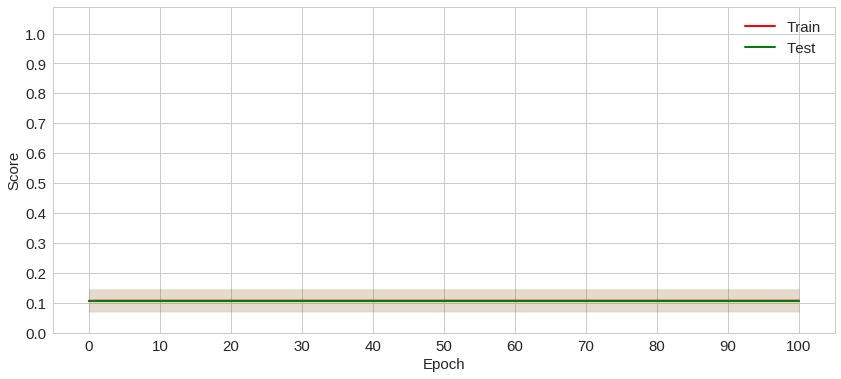

In [27]:
plot_mean_acc(hist)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

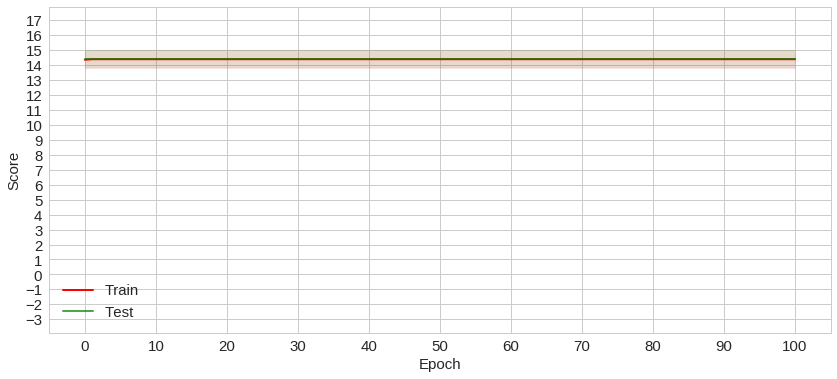

In [29]:
plot_mean_loss(hist)